In [1]:
!pip install --upgrade cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 7.5 MB/s 


In [3]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc


rc('animation', html='jshtml')

In [4]:
print(cp.__version__)

1.2.1


In [5]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [6]:
import math
print(math.pi)
print(math.exp(1))

3.141592653589793
2.718281828459045


# Setting and Hyperparameters

In [7]:
valuations = np.array([[21.26920423, 33.45640665],
 [21.06020981, 33.52635807]])

valuations = valuations / np.sum(valuations)

# Load Data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

utility_type = "linear"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_linear = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_linear = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_linear = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_linear = np.load(f)


# utility_type = "leontief"
# coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/coef_hist_{utility_type}_fisher.npy"
# intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
# values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
# budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

# with open(coef_hist_filename, 'rb') as f:
#     coef_hist_leontief = np.load(f)
# with open(intercept_hist_filename, 'rb') as f:
#     intercept_hist_leontief = np.load(f)
# with open(values_hist_filename, 'rb') as f:
#     values_hist_leontief = np.load(f)
# with open(budgets_hist_filename, 'rb') as f:
#     budgets_hist_leontief = np.load(f)


# utility_type = "cd"
# coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/coef_hist_{utility_type}_fisher.npy"
# intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
# values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
# budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

# with open(coef_hist_filename, 'rb') as f:
#     coef_hist_cd = np.load(f)
# with open(intercept_hist_filename, 'rb') as f:
#     intercept_hist_cd = np.load(f)
# with open(values_hist_filename, 'rb') as f:
#     values_hist_cd = np.load(f)
# with open(budgets_hist_filename, 'rb') as f:
#     budgets_hist_cd = np.load(f)

Mounted at /content/drive


In [9]:
print(coef_hist_linear[-1])
print(intercept_hist_linear[-1])

[4.46387049 4.88846439]
762.7325996584606


# Library

## utilities

In [10]:
################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

def get_cd_util(demands, valuations):
    util = np.sum(np.log(demands.clip(min = 0.001))*valuations, axis = 1) 
    return util 

#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )


################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


### JAX

In [11]:
from jax import device_put
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

#### Linear

In [12]:
def get_linear_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(valuations * demands, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_linear_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_linear_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[2.0,2.1],[2.2,2.3]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_linear_value = grad(jit(get_linear_value), argnums=1)
savings_grad_linear_value = grad(jit(get_linear_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

30.528
___________________JAX___________________
[[1.8837345 2.96311  ]
 [1.7043604 2.7132206]]
[-0.03138067 -0.12157232]
___________________BY HAND___________________
[[1.8837345 2.96311  ]
 [1.7043604 2.7132206]]
[-0.03138067 -0.12157232]


#### Leontief

In [13]:
def get_leontief_obj(prices, demands, budgets, valuations):
  utils = jnp.min(demands/valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils))

def get_leontief_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[1.2,2],[0.31, 2.31]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_leontief_value = grad(jit(get_leontief_value), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_leontief_util(demands, valuations).clip(min = 0.01)
marginals = get_leontief_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

51.926136
___________________JAX___________________
[[ 8.325     0.      ]
 [32.225803  0.      ]]
[-1.8192692  -0.47563937]
___________________BY HAND___________________
[[ 0.         5.2924423]
 [32.225807   0.       ]]
[-1.8192692 -0.4756394]


#### CD

In [14]:
def get_cd_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(jnp.log(demands)*valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_cd_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_cd_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[1.2,2],[0.31, 2.31]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_cd_value = grad(jit(get_cd_value), argnums=1)
savings_grad_cd_value = grad(jit(get_cd_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_cd_util(demands, valuations).clip(min = 0.01)
marginals = get_cd_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

-19.600986
___________________JAX___________________
[[  6.541517    6.1738744]
 [199.34865    42.587944 ]]
[1.3958538 3.46911  ]
___________________BY HAND___________________
[[  6.541517    6.1738744]
 [199.3486     42.587936 ]]
[1.3958538 3.4691098]


## get_max

In [15]:
def get_max_linear(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budget = saving + 9.5
    obj = cp.Maximize(valuation.T @ allocation + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

def get_max_leontief(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budget = saving + 9.5
    obj = cp.Maximize(cp.min(allocation / valuation) + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)


def get_max_cd(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budget = saving + 9.5
    obj = cp.Maximize(valuation.T @ cp.log(allocation) + gamma*(slope*next_budget+intercept))
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

## min-max step

In [16]:
def min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False):
  prices =np.zeros(valuations.shape[1]).clip(min = 10)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_value = get_linear_value
      demands_grad = demands_grad_linear_value
      savings_grad = savings_grad_linear_value

  elif utility_type == "leontief":
      get_value = get_leontief_value
      demands_grad = demands_grad_leontief_value
      savings_grad = savings_grad_leontief_value

  elif utility_type == "cd":
      get_value = get_cd_value
      demands_grad = demands_grad_cd_value
      savings_grad = savings_grad_cd_value

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      spendings = budgets - savings
      
      # Demand step
      demands_step = demands_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      demands += (iter_inner** (-1/2)) * learn_rate_demands * demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      savings_step = savings_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      savings += (iter_inner** (-1/2)) * learn_rate_demands * savings_step
      savings_step_sizes.append(np.linalg.norm(savings_step))


      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = np.array(savings)
      X.value = np.array(demands)

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 10e-2)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))
    prices = np.clip(prices, a_min=0.001, a_max = None)
    if test:
      print(prices)
      print(demands)
      print("-----------------------------------------------------")

  next_budgets = savings + np.array([9.5, 9.5])
  value = get_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  if test == False:
    return value, prices, demands, savings
  else:
    return prices_step_sizes, demands_step_sizes, savings_step_sizes

### Test min-max step

1.5
0.00065
[9.87152029 9.871219  ]
[[0.36147699 0.54835929]
 [0.55286987 0.36578672]]
-----------------------------------------------------
[9.76088258 9.76033515]
[[0.3683697  0.553325  ]
 [0.55787184 0.37275243]]
-----------------------------------------------------
[9.66598681 9.66523833]
[[0.37443505 0.55772093]
 [0.56230111 0.37888119]]
-----------------------------------------------------
[9.5848806  9.58396907]
[[0.37973608 0.5615831 ]
 [0.56619311 0.38423739]]
-----------------------------------------------------
[9.51577761 9.51473318]
[[0.38434135 0.56495293]
 [0.56958998 0.38888981]]
-----------------------------------------------------
[9.45706267 9.45591125]
[[0.38832017 0.56787594]
 [0.57253654 0.39290944]]
-----------------------------------------------------
[9.40729405 9.4060561 ]
[[0.39174212 0.57039725]
 [0.57507881 0.39636599]]
-----------------------------------------------------
[9.36519607 9.36388864]
[[0.39467271 0.57256223]
 [0.57726197 0.39932613]]
----------

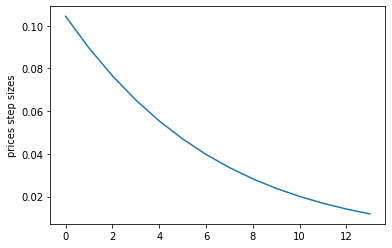

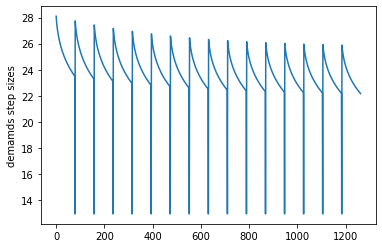

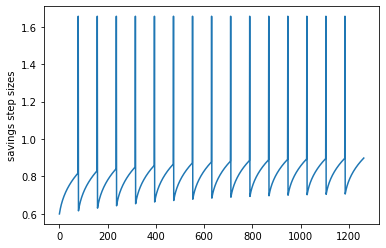

In [18]:
num_goods = 2
num_buyers = 2
num_samples = 25
discount = 0.9


valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

valuations = valuations / (np.sum(valuations))


num_iters_prices = 60
num_iters_demands = 80

value_coef = np.zeros(2)
value_intercept = 0


budgets = np.array([9.09845395, 9.18667045])


utility_type = "leontief"


learn_rate_prices = 1.5
learn_rate_demands = 6.5e-4

print(learn_rate_prices)
print(learn_rate_demands)


prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                 discount, learn_rate_prices, learn_rate_demands, 
                                                                                num_iters_prices, num_iters_demands, utility_type, test=True)
plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

plt.plot(demands_step_sizes[1:])
plt.ylabel("demamds step sizes")
plt.show()

plt.plot(savings_step_sizes[1:])
plt.ylabel("savings step sizes")
plt.show()

## single_buyer_val_iter

In [ ]:
def single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, gamma, slope, intercept, 
                          num_iters, num_samples, utility_type, fitted_value_coef, fitted_value_intercept):
    value_slope_hist = []
    value_intercept_hist = []
    values_hist = []
    budgets_hist = []

    if utility_type == "linear":
        get_max = get_max_linear
    elif utility_type == "leontief":
        get_max = get_max_leontief
    elif utility_type == "cd":
        get_max = get_max_cd

    value_slope = slope
    value_intercept = intercept
    value_slope_hist.append(value_slope)
    value_intercept_hist.append(value_intercept)
    num_buyers = valuations.shape[0]
    

    for iter in range(num_iters):
        print(f"-----------------------Iteration {iter}-------------------")
        values = []
        budget_list = []
        for index, budgets in enumerate(budgets_samples):
          print(f"___sample {index}___")
          value, demand, saving = get_max(budgets[buyer], valuations[buyer], prices_list[index], discount, value_slope, value_intercept)
          values.append(value)
          budget_list.append(budgets[buyer])
          print("buyer value:", value)
          print("buyer demands:", demand)

        values_hist.append(values)    
        budgets_hist.append(budget_list)
        print(budget_list)
        print(values)
        reg = linear_model.LinearRegression()
        reg.fit(np.array(budget_list).reshape(-1,1), np.array(values))
        value_slope = reg.coef_ # Update the slope
        value_intercept = reg.intercept_ # Update the intercept
        
        value_intercept_hist.append(value_intercept)
        value_slope_hist.append(value_slope)
        values_hist.append(values)
        budgets_hist.append(budgets)
        print("SLOPE", value_slope)
        print("INTERCEPT:", value_intercept)
    
    return value_slope, value_intercept, values_hist



## get_greedy_action

In [ ]:
def get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands):
  value, prices, demands, savings =  min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False)

  return (prices, demands, savings)

## get_buyers_cumulative_util

In [ ]:
def get_buyers_cumulative_util(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters):
  
  if utility_type == "linear":
      get_util = get_linear_util
  elif utility_type == "leontief":
      get_util = get_leontief_util
  elif utility_type == "cd":
      get_util = get_cd_util
  
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]
  cumul_utils = np.zeros(num_buyers)
  excess_demands_hist = []
  budgets = init_budgets   
  for iter in range(num_iters):
    print(f"--------------------cumulative iter {iter}---------------------")
    print(f"budgets: {budgets}")
    prices, demands, savings = get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands)
    if iter == 0:
      start_prices = prices
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    excess_demands_hist.append(np.linalg.norm(excess_demands))
    print("util:", get_util(demands, valuations))
    cumul_utils += (discount**iter)*get_util(demands, valuations)
    budgets = savings + np.array([9.5,9.5])

  return cumul_utils, excess_demands_hist


# Changes in Value Functions

## Plot

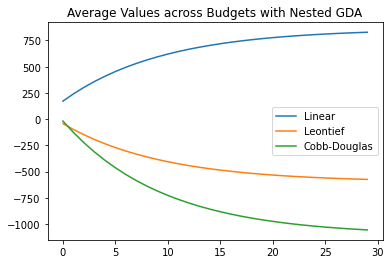

In [ ]:
avg_values_linear = np.average(values_hist_linear, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)
avg_values_leontief = np.average(values_hist_leontief, axis = 1)
# avg_values_leontief = avg_values_leontief/ np.sum(avg_values_leontief)
avg_values_cd = np.average(values_hist_cd, axis = 1)
# avg_values_cd= avg_values_cd / np.sum(avg_values_cd)

fig, ax = plt.subplots()
ax.set_title('Average Values across Budgets with Nested GDA')
ax.plot(np.arange(0, avg_values_linear.shape[0]), avg_values_linear, label = "Linear")
ax.plot(np.arange(0, avg_values_leontief.shape[0]), avg_values_leontief, label = "Leontief")
ax.plot(np.arange(0, avg_values_cd.shape[0]), avg_values_cd, label = "Cobb-Douglas")
ax.legend()
fig.show()


# Distance to Utility Maximization

## Single_buyer_val_iter

In [ ]:
discount = 0.9

slope = 0
intercept = 0

num_iters = 50
num_samples = 15
utility_type = "linear"


budgets = np.array([10,10])
fitted_value_coef = coef_hist_linear[-1]
fitted_value_intercept = intercept_hist_linear[-1]
print(fitted_value_coef)
print(fitted_value_intercept)
learn_rate_prices = 1
learn_rate_demands = 1
num_iters_prices = 60 #30
num_iters_demands = 100


[4.46387049 4.88846439]
762.7325996584606


##### Get budgets-prices pairs for value iterations

In [ ]:
num_buyers = valuations.shape[0]
budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
prices_list = []
learn_rate_prices = 1.7
learn_rate_demands = 0.02
for index, budgets in enumerate(budgets_samples):
    print(f"-------------------------Sample {index}--------------------------------")
    min_max_value, prices, demands, savings = min_max_linear_value_jax(budgets, valuations, fitted_value_coef, fitted_value_intercept, discount, 
                                                                      learn_rate_prices, learn_rate_demands,
                                                                      num_iters_prices, num_iters_demands, utility_type, test=False)
    prices_list.append(prices)

print(prices_list)

-------------------------Sample 0--------------------------------
Early end! Excess demand norm: 0.009661877189050616
------------------------------------------------------------------
budgets: [9.79885574 9.68165998]
demands: [[0.52260824 0.47952944]
 [0.47078114 0.51342417]]
prices: [ 9.12290911 10.49184411]
value: 861.7532
excess demands: [-0.00661062 -0.00704639]
-------------------------Sample 1--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.009504805826735647
------------------------------------------------------------------
budgets: [9.33349328 9.17450888]
demands: [[0.52285088 0.48179315]
 [0.47098567 0.51097131]]
prices: [8.67037618 9.96315403]
value: 856.99384
excess demands: [-0.00616346 -0.00723555]
-------------------------Sample 2--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.008712268363846329
------------------------------------------------------------------
budg

##### Single buyer value iteration

In [ ]:
slope = 0
intercept = 0
learned_slopes = []
learned_intercepts = []
cumul_utils_single = []
values_hists = []

for buyer in range(num_buyers):
  opt_value_slope, opt_value_intercept, values_hist = single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, discount, slope, intercept, num_iters, num_samples, 
                                                                                            utility_type, fitted_value_coef, fitted_value_intercept)
  print(f"cumul util: {opt_value_slope * budgets[buyer-1] + opt_value_intercept}")
  print(f"slope: {opt_value_slope}")
  print(f"intercept: {opt_value_intercept}")
  cumul_utils_single.append(opt_value_slope * budgets[buyer-1] + opt_value_intercept)
  values_hists.append(values_hist)
  learned_slopes.append(opt_value_slope)
  learned_intercepts.append(opt_value_intercept)

Streaming output truncated to the last 5000 lines.
buyer demands: [0.         0.93680106]
___sample 2___
buyer value: 49.265136518790534
buyer demands: [0.         0.93916339]
___sample 3___
buyer value: 48.79165519578749
buyer demands: [0.        0.9301372]
___sample 4___
buyer value: 49.71018541479439
buyer demands: [0.         0.94764755]
___sample 5___
buyer value: 47.12719224814511
buyer demands: [0.        0.8984068]
___sample 6___
buyer value: 47.73038573411477
buyer demands: [0.         0.90990574]
___sample 7___
buyer value: 48.26486581106466
buyer demands: [0.         0.92009478]
___sample 8___
buyer value: 48.389115855196536
buyer demands: [0.         0.92246341]
___sample 9___
buyer value: 47.6294193840238
buyer demands: [0.         0.90798098]
___sample 10___
buyer value: 48.280893059818396
buyer demands: [0.         0.92040031]
___sample 11___
buyer value: 48.92659350802862
buyer demands: [0.         0.93270959]
___sample 12___
buyer value: 49.4976953787187
buyer demands:

##### Cumulative utils single

[483.87497446 495.7175902 ]


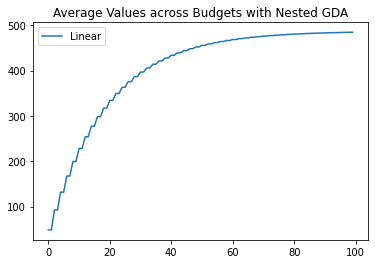

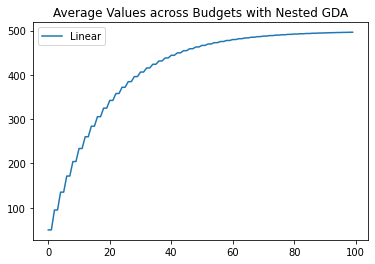

In [ ]:
print(np.array([util[0] for util in cumul_utils_single]))

for values_hist in values_hists:
  avg_values = np.average(values_hist, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)


  fig, ax = plt.subplots()
  ax.set_title('Average Values across Budgets with Nested GDA')
  ax.plot(np.arange(0, avg_values.shape[0]), avg_values, label = "Linear")
  ax.legend()
  fig.show()

## Cumul_util both buyers

In [ ]:
init_budgets = np.array([10, 10])
print(fitted_value_coef)
print(fitted_value_intercept)
num_iters_prices = 60
num_iters_demands = 100
num_iters = 50
discount = 0.9
learn_rate_prices = 1.7
learn_rate_demands = 0.02
utility_type = "linear"
cumul_utils, excess_demands_hist =  get_buyers_cumulative_util(init_budgets, valuations, utility_type, fitted_value_coef, fitted_value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters)

[4.46387049 4.88846439]
762.7325996584606
--------------------cumulative iter 0---------------------
budgets: [10 10]
Early end! Excess demand norm: 0.0072685533124433625
------------------------------------------------------------------
budgets: [10 10]
demands: [[0.52557823 0.47636733]
 [0.47824946 0.51745362]]
prices: [ 9.30817086 10.72244395]
value: 864.2944
excess demands: [ 0.00382769 -0.00617905]
util: [48.78102672 49.24742878]
--------------------cumulative iter 1---------------------
budgets: [9.50000371 9.50000256]

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.009797108818324431
------------------------------------------------------------------
budgets: [9.50000371 9.50000256]
demands: [[0.51941576 0.47661982]
 [0.47425114 0.51590521]]
prices: [ 8.90042886 10.23242094]
value: 859.4018
excess demands: [-0.0063331  -0.00747497]
util: [48.5153013  48.98438275]
--------------------cumulative iter 2---------------------
budgets: [9.50000374 9.50000247]

****

In [ ]:
print(excess_demands_hist)
print(np.mean(excess_demands_hist))

[0.0072685533124433625, 0.009797108818324431, 0.009797106764924055, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 0.009797106765700482, 0.00979710676570135, 0.009797106765701035, 

In [ ]:
print(cumul_utils)

[482.91837097 487.58232803]


## Results

In [ ]:
cumul_utils = np.array([483.87497446, 495.7175902 ])
cumul_utils_single = np.array([482.91837097, 487.58232803])

In [ ]:
print(np.linalg.norm(cumul_utils-cumul_utils_single))
print(np.linalg.norm(cumul_utils-cumul_utils_single) / np.linalg.norm(cumul_utils_single))

8.191311299890497
0.011936240519018067
